In [97]:
#定义一个因子的列表，需要去掉收盘价和开盘价，包括了 label 列
factor_list2 =['ROA','ROE','DVRAT','DAVOL5','DVRAT','HBETA','HSIGMA','RSI',
               'turnoverRate','VOL5','turnoverVol','VEMA5','turnoverValue',
               'TVMA6','ATR6','OBV','PVI','EPS','BIAS5','CCI5','ROC6','CMO',
               'PVT','BearPower','BullPower','EMA5','MA5','MACD','BollDown',
               'BollUp','KDJ_K','highestPrice','lowestPrice','negMarketValue',
               'marketValue','PE','PE1','PB','label']
len(factor_list2)

39

In [92]:
#数据区间将分为三个时间段：时间期限为一年、两年、五年
#PCA-标准化
#为剔除这种因素的影响，将整个数据分成两部分，将训练集进行交叉验证，测试集单独测试(样本外测试)
#分类模型-SVC
#标准化后的数据-GridSearchCV（kernel=linear/rbf，cv=5）
#PCA 后的数据-GridSearchCV（kernel=Linear/rbf，cv=5）
import pandas as pd
import numpy as np
from time import time
from pandas import Series, DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [93]:
#读取数据
data = pd.read_csv('quotation.csv')  #读取平安银行的沪深日行情数据
data['tradeDate'] = pd.to_datetime(data['tradeDate'])  #更改数据的日期格式为默认格式
data = data.set_index('tradeDate')  #将日期作为索引项
data = data.iloc[0:, 6:24]  #从首行开始到结尾，从第6列到23列，即读取所有有用数据
data

,actPreClosePrice,openPrice,highestPrice,lowestPrice,closePrice,turnoverVol,turnoverValue,dealAmount,turnoverRate,accumAdjFactor,negMarketValue,marketValue,chgPct,PE,PE1,PB,isOpen,vwap
tradeDate,,,,,,,,,,,,,,,,,,
2013-07-01,9.97,9.81,9.95,9.44,9.75,80019664,7.753960e+08,27440,0.0161,0.526178,4.844360e+10,7.992427e+10,-0.0221,5.6395,5.3064,0.8731,1,9.690
2013-07-02,9.75,9.78,9.80,9.37,9.60,81375376,7.761866e+08,32443,0.0164,0.526178,4.769831e+10,7.869466e+10,-0.0154,5.5527,5.2247,0.8597,1,9.538
2013-07-03,9.60,9.55,9.55,9.27,9.33,77115848,7.235820e+08,24350,0.0155,0.526178,4.635679e+10,7.648138e+10,-0.0281,5.3966,5.0778,0.8355,1,9.383
2013-07-04,9.33,9.22,9.57,9.01,9.37,80515992,7.503475e+08,29577,0.0162,0.526178,4.655554e+10,7.680927e+10,0.0043,5.4197,5.0995,0.8391,1,9.319
2013-07-05,9.37,9.35,9.57,9.34,9.37,64144624,6.062325e+08,22003,0.0129,0.526178,4.655554e+10,7.680927e+10,0.0000,5.4197,5.0995,0.8391,1,9.451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-04,8.67,8.63,8.75,8.61,8.61,71115337,6.172786e+08,27236,0.0041,0.957550,1.478358e+11,1.478372e+11,-0.0069,6.2723,5.6041,0.6618,1,8.680
2018-07-05,8.61,8.62,8.73,8.55,8.60,83576877,7.221696e+08,25107,0.0049,0.957550,1.476641e+11,1.476655e+11,-0.0012,6.2650,5.5976,0.6610,1,8.641
2018-07-06,8.60,8.61,8.78,8.45,8.66,98828269,8.520715e+08,32688,0.0058,0.957550,1.486943e+11,1.486958e+11,0.0070,6.3087,5.6367,0.6656,1,8.622


In [94]:
factors = pd.read_csv('factors.csv')  #读取平安银行的量化因子数据
factors['tradeDate'] = pd.to_datetime(factors['tradeDate'])
factors = factors.set_index('tradeDate')
factors = factors[0:]  #从首行开始到结尾
factors

,Unnamed: 0,secID,ticker,AccountsPayablesTDays,AccountsPayablesTRate,AdminiExpenseRate,ARTDays,ARTRate,ASSI,BLEV,...,CR20,MassIndex,BearPower,BullPower,Elder,NVI,PVI,RC12,RC24,JDQS20
tradeDate,,,,,,,,,,,,,,,,,,,,,
2013-07-01,0,000001.XSHE,1,NaN,NaN,NaN,NaN,NaN,28.2250,NaN,...,31.2808,25.7618,-1.2671,-0.7564,0.0524,7.8355,2058.6676,0.8376,0.7670,0.1538
2013-07-02,1,000001.XSHE,1,NaN,NaN,NaN,NaN,NaN,28.2250,NaN,...,30.4492,25.8450,-1.1791,-0.7480,0.0449,7.8355,2026.6352,0.8129,0.7488,0.1538
2013-07-03,2,000001.XSHE,1,NaN,NaN,NaN,NaN,NaN,28.2250,NaN,...,28.4443,25.8383,-1.1050,-0.8256,0.0299,7.6165,2026.6352,0.7828,0.7376,0.1538
2013-07-04,3,000001.XSHE,1,NaN,NaN,NaN,NaN,NaN,28.2250,NaN,...,29.8549,25.8648,-1.2205,-0.6617,0.0596,7.6165,2035.0745,0.7666,0.7001,0.1667
2013-07-05,4,000001.XSHE,1,NaN,NaN,NaN,NaN,NaN,28.2250,NaN,...,30.5536,25.6154,-0.7680,-0.5386,0.0245,7.6165,2035.0745,0.7861,0.7107,0.1667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-04,1223,000001.XSHE,1,NaN,NaN,NaN,NaN,NaN,28.8366,NaN,...,38.2519,26.2122,-0.6097,-0.4704,0.0162,1.4551,17816.8403,0.8466,0.8542,0.2143
2018-07-05,1224,000001.XSHE,1,NaN,NaN,NaN,NaN,NaN,28.8366,NaN,...,39.3958,26.1398,-0.5811,-0.4012,0.0209,1.4551,17795.8125,0.8713,0.8448,0.2143
2018-07-06,1225,000001.XSHE,1,NaN,NaN,NaN,NaN,NaN,28.8366,NaN,...,34.1461,26.1554,-0.6143,-0.2841,0.0381,1.4551,17919.8764,0.8739,0.8498,0.1538


In [95]:
#定义选取的量化因子，共 76 个，减掉了滚动市盈率和PB，因为沪深日行情数据里有，
#但是在Data这个数据里还缺几个，包括总市值等
factor_list=["ROA","ROA5","ROE","ROE5","CMRA","DVRAT","HBETA","HSIGMA","DAVOL10",
             "DAVOL20","DAVOL5","RSI","VOL10","VOL120","VOL20","VOL240","VOL5",
             "VOL60","ATR14","ATR6","OBV","OBV6","OBV20","TVMA20","TVMA6","TVSTD20",
             "TVSTD6","VEMA10","VEMA12","VEMA26","VEMA5","VMACD","PVI","EPS","ETOP",
             "LCAP","LFLO","PCF","PS","RSTR12","RSTR24","BIAS10","BIAS20","BIAS5",
             "BIAS60","CCI10","CCI20","CCI5","CCI88","ROC6","ROC20","CMO","DDI",
             "PVT","PVT6","PVT12","BearPower","BullPower","EGRO","NetProfitGrowRate",
             "DHILO","EMA10","EMA120","EMA20","EMA5","EMA60","MA10","MA120","MA20",
             "MA5","MA60","MACD","BollDown","BollUp","KDJ_K","KDJ_D"]
len(factor_list)

76

In [1]:
#再次定义因子，包括了从行情数据里面的因子，直接添加到 factor_list 里面，
#加上这里 13 个因子，一共会有89个因子；
#再加上将会构建的第二天的收盘价，应该会有90个因子，90列
factor_list1 =["openPrice","highestPrice","lowestPrice","closePrice","turnoverVol",
               "turnoverValue","turnoverRate","negMarketValue","marketValue",
               "chgPct","PE","PE1","PB","ROA","ROA5","ROE","ROE5","CMRA","DVRAT",
               "HBETA","HSIGMA","DAVOL10","DAVOL20","DAVOL5","RSI","VOL10","VOL120",
               "VOL20","VOL240","VOL5","VOL60","ATR14","ATR6","OBV","OBV6","OBV20",
               "TVMA20","TVMA6","TVSTD20","TVSTD6","VEMA10","VEMA12","VEMA26",
               "VEMA5","VMACD","PVI","EPS","ETOP","LCAP","LFLO","PCF","PS","RSTR12",
               "RSTR24","BIAS10","BIAS20","BIAS5","BIAS60","CCI10","CCI20","CCI5",
               "CCI88","ROC6","ROC20","CMO","DDI","PVT","PVT6","PVT12","BearPower",
               "BullPower","EGRO","NetProfitGrowRate","DHILO","EMA10","EMA120","EMA20",
               "EMA5","EMA60","MA10","MA120","MA20","MA5","MA60","MACD","BollDown",
               "BollUp","KDJ_K","KDJ_D"]
len(factor_list1)

89

In [98]:
#去掉label列
factor_list3 =['ROA','ROE','DVRAT','DAVOL5','DVRAT','HBETA','HSIGMA','RSI',
               'turnoverRate','VOL5','turnoverVol','VEMA5','turnoverValue',
               'TVMA6','ATR6','OBV','PVI','EPS','BIAS5','CCI5','ROC6','CMO',
               'PVT','BearPower','BullPower','EMA5','MA5','MACD','BollDown',
               'BollUp','KDJ_K','highestPrice','lowestPrice','negMarketValue',
               'marketValue','PE','PE1','PB']
len(factor_list3)

38

In [99]:
#先按照 list 取出多的量化因子数据
factors=factors.loc[:, factor_list]
factors

,ROA,ROA5,ROE,ROE5,CMRA,DVRAT,HBETA,HSIGMA,DAVOL10,DAVOL20,...,MA10,MA120,MA20,MA5,MA60,MACD,BollDown,BollUp,KDJ_K,KDJ_D
tradeDate,,,,,,,,,,,,,,,,,,,,,
2013-07-01,0.0092,0.0105,0.1679,0.2275,0.5907,0.0005,1.4993,0.0167,-0.0009,-0.0041,...,10.5811,12.2599,11.5414,9.8119,12.0791,-0.4612,9.0239,14.0588,20.0831,19.2873
2013-07-02,0.0092,0.0105,0.1679,0.2275,0.5907,0.0266,1.5008,0.0167,-0.0006,-0.0041,...,10.3187,12.2629,11.3646,9.7357,12.0324,-0.4114,8.8219,13.9073,17.9014,18.8253
2013-07-03,0.0092,0.0105,0.1679,0.2275,0.5860,0.0506,1.5162,0.0166,-0.0002,-0.0039,...,10.0599,12.2611,11.1809,9.6499,11.9801,-0.3822,8.6063,13.7556,13.0119,16.8876
2013-07-04,0.0092,0.0105,0.1679,0.2275,0.6076,0.0717,1.5171,0.0166,-0.0004,-0.0036,...,9.8789,12.2598,11.0017,9.6040,11.9258,-0.3278,8.4480,13.5553,16.2882,16.6878
2013-07-05,0.0092,0.0105,0.1679,0.2275,0.5499,0.0883,1.5180,0.0166,-0.0005,-0.0038,...,9.6880,12.2580,10.8156,9.4841,11.8709,-0.2646,8.3626,13.2686,24.7290,19.3682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-04,0.0076,0.0092,0.1097,0.1485,0.4910,0.1797,1.3954,0.0170,-0.0017,-0.0018,...,9.1521,11.5856,9.6111,8.7802,10.5217,-0.1864,8.4495,10.7727,10.9914,11.4707
2018-07-05,0.0076,0.0092,0.1097,0.1485,0.4890,0.1939,1.3923,0.0170,-0.0017,-0.0018,...,9.0261,11.5468,9.5341,8.7162,10.4814,-0.1656,8.3173,10.7509,10.5834,11.1238
2018-07-06,0.0076,0.0092,0.1097,0.1485,0.5240,0.2059,1.3792,0.0165,-0.0015,-0.0018,...,8.9071,11.5082,9.4486,8.6302,10.4354,-0.1290,8.2389,10.6584,16.5897,13.7624


In [100]:
#合成一个 DataFrame
data = data.join(factors)
data

,actPreClosePrice,openPrice,highestPrice,lowestPrice,closePrice,turnoverVol,turnoverValue,dealAmount,turnoverRate,accumAdjFactor,...,MA10,MA120,MA20,MA5,MA60,MACD,BollDown,BollUp,KDJ_K,KDJ_D
tradeDate,,,,,,,,,,,,,,,,,,,,,
2013-07-01,9.97,9.81,9.95,9.44,9.75,80019664,7.753960e+08,27440,0.0161,0.526178,...,10.5811,12.2599,11.5414,9.8119,12.0791,-0.4612,9.0239,14.0588,20.0831,19.2873
2013-07-02,9.75,9.78,9.80,9.37,9.60,81375376,7.761866e+08,32443,0.0164,0.526178,...,10.3187,12.2629,11.3646,9.7357,12.0324,-0.4114,8.8219,13.9073,17.9014,18.8253
2013-07-03,9.60,9.55,9.55,9.27,9.33,77115848,7.235820e+08,24350,0.0155,0.526178,...,10.0599,12.2611,11.1809,9.6499,11.9801,-0.3822,8.6063,13.7556,13.0119,16.8876
2013-07-04,9.33,9.22,9.57,9.01,9.37,80515992,7.503475e+08,29577,0.0162,0.526178,...,9.8789,12.2598,11.0017,9.6040,11.9258,-0.3278,8.4480,13.5553,16.2882,16.6878
2013-07-05,9.37,9.35,9.57,9.34,9.37,64144624,6.062325e+08,22003,0.0129,0.526178,...,9.6880,12.2580,10.8156,9.4841,11.8709,-0.2646,8.3626,13.2686,24.7290,19.3682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-04,8.67,8.63,8.75,8.61,8.61,71115337,6.172786e+08,27236,0.0041,0.957550,...,9.1521,11.5856,9.6111,8.7802,10.5217,-0.1864,8.4495,10.7727,10.9914,11.4707
2018-07-05,8.61,8.62,8.73,8.55,8.60,83576877,7.221696e+08,25107,0.0049,0.957550,...,9.0261,11.5468,9.5341,8.7162,10.4814,-0.1656,8.3173,10.7509,10.5834,11.1238
2018-07-06,8.60,8.61,8.78,8.45,8.66,98828269,8.520715e+08,32688,0.0058,0.957550,...,8.9071,11.5082,9.4486,8.6302,10.4354,-0.1290,8.2389,10.6584,16.5897,13.7624


In [101]:
#标记涨跌分类，收盘价高于开盘价，标记为 1，记为股价上涨；
#收盘价低于开盘价，标记为-1，记为股价下跌
data['label'] = np.where(data['closePrice'] > data['openPrice'], 1, -1)
data

,actPreClosePrice,openPrice,highestPrice,lowestPrice,closePrice,turnoverVol,turnoverValue,dealAmount,turnoverRate,accumAdjFactor,...,MA120,MA20,MA5,MA60,MACD,BollDown,BollUp,KDJ_K,KDJ_D,label
tradeDate,,,,,,,,,,,,,,,,,,,,,
2013-07-01,9.97,9.81,9.95,9.44,9.75,80019664,7.753960e+08,27440,0.0161,0.526178,...,12.2599,11.5414,9.8119,12.0791,-0.4612,9.0239,14.0588,20.0831,19.2873,-1
2013-07-02,9.75,9.78,9.80,9.37,9.60,81375376,7.761866e+08,32443,0.0164,0.526178,...,12.2629,11.3646,9.7357,12.0324,-0.4114,8.8219,13.9073,17.9014,18.8253,-1
2013-07-03,9.60,9.55,9.55,9.27,9.33,77115848,7.235820e+08,24350,0.0155,0.526178,...,12.2611,11.1809,9.6499,11.9801,-0.3822,8.6063,13.7556,13.0119,16.8876,-1
2013-07-04,9.33,9.22,9.57,9.01,9.37,80515992,7.503475e+08,29577,0.0162,0.526178,...,12.2598,11.0017,9.6040,11.9258,-0.3278,8.4480,13.5553,16.2882,16.6878,1
2013-07-05,9.37,9.35,9.57,9.34,9.37,64144624,6.062325e+08,22003,0.0129,0.526178,...,12.2580,10.8156,9.4841,11.8709,-0.2646,8.3626,13.2686,24.7290,19.3682,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-04,8.67,8.63,8.75,8.61,8.61,71115337,6.172786e+08,27236,0.0041,0.957550,...,11.5856,9.6111,8.7802,10.5217,-0.1864,8.4495,10.7727,10.9914,11.4707,-1
2018-07-05,8.61,8.62,8.73,8.55,8.60,83576877,7.221696e+08,25107,0.0049,0.957550,...,11.5468,9.5341,8.7162,10.4814,-0.1656,8.3173,10.7509,10.5834,11.1238,-1
2018-07-06,8.60,8.61,8.78,8.45,8.66,98828269,8.520715e+08,32688,0.0058,0.957550,...,11.5082,9.4486,8.6302,10.4354,-0.1290,8.2389,10.6584,16.5897,13.7624,1


In [102]:
#进行平移操作,将第二天的涨跌移回前一天作为预测值的训练集
data['label'] = data['label'].shift(-1)
data

,actPreClosePrice,openPrice,highestPrice,lowestPrice,closePrice,turnoverVol,turnoverValue,dealAmount,turnoverRate,accumAdjFactor,...,MA120,MA20,MA5,MA60,MACD,BollDown,BollUp,KDJ_K,KDJ_D,label
tradeDate,,,,,,,,,,,,,,,,,,,,,
2013-07-01,9.97,9.81,9.95,9.44,9.75,80019664,7.753960e+08,27440,0.0161,0.526178,...,12.2599,11.5414,9.8119,12.0791,-0.4612,9.0239,14.0588,20.0831,19.2873,-1.0
2013-07-02,9.75,9.78,9.80,9.37,9.60,81375376,7.761866e+08,32443,0.0164,0.526178,...,12.2629,11.3646,9.7357,12.0324,-0.4114,8.8219,13.9073,17.9014,18.8253,-1.0
2013-07-03,9.60,9.55,9.55,9.27,9.33,77115848,7.235820e+08,24350,0.0155,0.526178,...,12.2611,11.1809,9.6499,11.9801,-0.3822,8.6063,13.7556,13.0119,16.8876,1.0
2013-07-04,9.33,9.22,9.57,9.01,9.37,80515992,7.503475e+08,29577,0.0162,0.526178,...,12.2598,11.0017,9.6040,11.9258,-0.3278,8.4480,13.5553,16.2882,16.6878,1.0
2013-07-05,9.37,9.35,9.57,9.34,9.37,64144624,6.062325e+08,22003,0.0129,0.526178,...,12.2580,10.8156,9.4841,11.8709,-0.2646,8.3626,13.2686,24.7290,19.3682,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-04,8.67,8.63,8.75,8.61,8.61,71115337,6.172786e+08,27236,0.0041,0.957550,...,11.5856,9.6111,8.7802,10.5217,-0.1864,8.4495,10.7727,10.9914,11.4707,-1.0
2018-07-05,8.61,8.62,8.73,8.55,8.60,83576877,7.221696e+08,25107,0.0049,0.957550,...,11.5468,9.5341,8.7162,10.4814,-0.1656,8.3173,10.7509,10.5834,11.1238,1.0
2018-07-06,8.60,8.61,8.78,8.45,8.66,98828269,8.520715e+08,32688,0.0058,0.957550,...,11.5082,9.4486,8.6302,10.4354,-0.1290,8.2389,10.6584,16.5897,13.7624,1.0


In [103]:
#按照 list2 取数据，不包括了收盘价和开盘价，但包括 label
data_1 = data.loc[:, factor_list2]
data_1 = data_1.dropna()
data_1

,ROA,ROE,DVRAT,DAVOL5,DVRAT,HBETA,HSIGMA,RSI,turnoverRate,VOL5,...,BollUp,KDJ_K,highestPrice,lowestPrice,negMarketValue,marketValue,PE,PE1,PB,label
tradeDate,,,,,,,,,,,,,,,,,,,,,
2013-07-01,0.0092,0.1679,0.0005,0.0019,0.0005,1.4993,0.0167,26.3207,0.0161,0.0213,...,14.0588,20.0831,9.95,9.44,4.844360e+10,7.992427e+10,5.6395,5.3064,0.8731,-1.0
2013-07-02,0.0092,0.1679,0.0266,-0.0018,0.0266,1.5008,0.0167,22.2326,0.0164,0.0177,...,13.9073,17.9014,9.80,9.37,4.769831e+10,7.869466e+10,5.5527,5.2247,0.8597,-1.0
2013-07-03,0.0092,0.1679,0.0506,-0.0028,0.0506,1.5162,0.0166,18.7025,0.0155,0.0167,...,13.7556,13.0119,9.55,9.27,4.635679e+10,7.648138e+10,5.3966,5.0778,0.8355,1.0
2013-07-04,0.0092,0.1679,0.0717,-0.0029,0.0717,1.5171,0.0166,13.1453,0.0162,0.0166,...,13.5553,16.2882,9.57,9.01,4.655554e+10,7.680927e+10,5.4197,5.0995,0.8391,1.0
2013-07-05,0.0092,0.1679,0.0883,-0.0042,0.0883,1.5180,0.0166,14.2635,0.0129,0.0154,...,13.2686,24.7290,9.57,9.34,4.655554e+10,7.680927e+10,5.4197,5.0995,0.8391,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-03,0.0076,0.1097,0.1642,-0.0013,0.1642,1.4011,0.0170,17.2922,0.0074,0.0063,...,10.7882,12.0099,8.70,8.45,1.488660e+11,1.488675e+11,6.3160,5.6432,0.6664,-1.0
2018-07-04,0.0076,0.1097,0.1797,-0.0016,0.1797,1.3954,0.0170,12.8329,0.0041,0.0059,...,10.7727,10.9914,8.75,8.61,1.478358e+11,1.478372e+11,6.2723,5.6041,0.6618,-1.0
2018-07-05,0.0076,0.1097,0.1939,-0.0019,0.1939,1.3923,0.0170,14.8876,0.0049,0.0056,...,10.7509,10.5834,8.73,8.55,1.476641e+11,1.476655e+11,6.2650,5.5976,0.6610,1.0


In [104]:
#分割训练集和测试集以及 feature 和 lable
num = 190  #确定数量
X_train = data_1.iloc[:num, :38]
X_train

,ROA,ROE,DVRAT,DAVOL5,DVRAT,HBETA,HSIGMA,RSI,turnoverRate,VOL5,...,BollDown,BollUp,KDJ_K,highestPrice,lowestPrice,negMarketValue,marketValue,PE,PE1,PB
tradeDate,,,,,,,,,,,,,,,,,,,,,
2013-07-01,0.0092,0.1679,0.0005,0.0019,0.0005,1.4993,0.0167,26.3207,0.0161,0.0213,...,9.0239,14.0588,20.0831,9.95,9.44,4.844360e+10,7.992427e+10,5.6395,5.3064,0.8731
2013-07-02,0.0092,0.1679,0.0266,-0.0018,0.0266,1.5008,0.0167,22.2326,0.0164,0.0177,...,8.8219,13.9073,17.9014,9.80,9.37,4.769831e+10,7.869466e+10,5.5527,5.2247,0.8597
2013-07-03,0.0092,0.1679,0.0506,-0.0028,0.0506,1.5162,0.0166,18.7025,0.0155,0.0167,...,8.6063,13.7556,13.0119,9.55,9.27,4.635679e+10,7.648138e+10,5.3966,5.0778,0.8355
2013-07-04,0.0092,0.1679,0.0717,-0.0029,0.0717,1.5171,0.0166,13.1453,0.0162,0.0166,...,8.4480,13.5553,16.2882,9.57,9.01,4.655554e+10,7.680927e+10,5.4197,5.0995,0.8391
2013-07-05,0.0092,0.1679,0.0883,-0.0042,0.0883,1.5180,0.0166,14.2635,0.0129,0.0154,...,8.3626,13.2686,24.7290,9.57,9.34,4.655554e+10,7.680927e+10,5.4197,5.0995,0.8391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-04-04,0.0086,0.1692,0.0001,-0.0049,0.0001,1.4981,0.0159,68.3047,0.0061,0.0067,...,10.0781,11.0662,59.8792,10.82,10.59,6.016398e+10,1.027288e+11,6.1529,5.0816,0.8758
2014-04-08,0.0086,0.1692,-0.0068,-0.0013,-0.0068,1.5048,0.0159,81.7547,0.0241,0.0103,...,10.0505,11.1906,71.5905,11.49,10.78,6.289617e+10,1.073940e+11,6.4323,5.3123,0.9155
2014-04-09,0.0086,0.1692,-0.0057,-0.0003,-0.0057,1.5025,0.0159,65.9292,0.0100,0.0113,...,10.0739,11.2624,68.7194,11.35,11.16,6.239434e+10,1.065371e+11,6.3810,5.2699,0.9082


In [105]:
Y_train = data_1.iloc[:num, 38]
Y_train

tradeDate
2013-07-01   -1.0
2013-07-02   -1.0
2013-07-03    1.0
2013-07-04    1.0
2013-07-05   -1.0
             ... 
2014-04-04    1.0
2014-04-08   -1.0
2014-04-09    1.0
2014-04-10    1.0
2014-04-11   -1.0
Name: label, Length: 190, dtype: float64

In [106]:
X_test = data_1.iloc[num:, :38]
X_test

,ROA,ROE,DVRAT,DAVOL5,DVRAT,HBETA,HSIGMA,RSI,turnoverRate,VOL5,...,BollDown,BollUp,KDJ_K,highestPrice,lowestPrice,negMarketValue,marketValue,PE,PE1,PB
tradeDate,,,,,,,,,,,,,,,,,,,,,
2014-04-14,0.0086,0.1692,-0.0024,0.0015,-0.0024,1.4976,0.0159,72.3891,0.0076,0.0132,...,10.0922,11.5249,70.8765,11.45,11.19,6.289617e+10,1.073940e+11,6.4323,5.3123,0.9155
2014-04-15,0.0086,0.1692,-0.0051,-0.0014,-0.0051,1.4964,0.0158,56.5217,0.0096,0.0103,...,10.1322,11.5350,52.9798,11.23,10.91,6.116764e+10,1.044426e+11,6.2555,5.1663,0.8904
2014-04-16,0.0086,0.1692,-0.0053,-0.0019,-0.0053,1.4832,0.0158,56.8345,0.0068,0.0097,...,10.1933,11.5348,48.9794,11.13,10.86,6.127916e+10,1.046330e+11,6.2669,5.1758,0.8920
2014-04-17,0.0086,0.1692,-0.0056,-0.0036,-0.0056,1.4834,0.0158,53.9863,0.0055,0.0080,...,10.2943,11.5000,40.8691,11.08,10.83,6.077733e+10,1.037761e+11,6.2156,5.1334,0.8847
2014-04-18,0.0086,0.1692,-0.0052,-0.0043,-0.0052,1.4744,0.0158,50.0000,0.0058,0.0071,...,10.4560,11.4082,25.4659,10.88,10.72,6.021974e+10,1.028241e+11,6.1586,5.0863,0.8766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-03,0.0076,0.1097,0.1642,-0.0013,0.1642,1.4011,0.0170,17.2922,0.0074,0.0063,...,8.5989,10.7882,12.0099,8.70,8.45,1.488660e+11,1.488675e+11,6.3160,5.6432,0.6664
2018-07-04,0.0076,0.1097,0.1797,-0.0016,0.1797,1.3954,0.0170,12.8329,0.0041,0.0059,...,8.4495,10.7727,10.9914,8.75,8.61,1.478358e+11,1.478372e+11,6.2723,5.6041,0.6618
2018-07-05,0.0076,0.1097,0.1939,-0.0019,0.1939,1.3923,0.0170,14.8876,0.0049,0.0056,...,8.3173,10.7509,10.5834,8.73,8.55,1.476641e+11,1.476655e+11,6.2650,5.5976,0.6610


In [107]:
Y_test = data_1.iloc[num:, 38]
Y_test

tradeDate
2014-04-14   -1.0
2014-04-15    1.0
2014-04-16   -1.0
2014-04-17   -1.0
2014-04-18   -1.0
             ... 
2018-07-03   -1.0
2018-07-04   -1.0
2018-07-05    1.0
2018-07-06    1.0
2018-07-09   -1.0
Name: label, Length: 1034, dtype: float64

In [108]:
#提供 X_train 数据的统计分析情况
X_train.count()
min_X = Series(X_train.min())
max_X = Series(X_train.max())
mean_X = Series(X_train.mean())
median_X = Series(X_train.median())
std_X = Series(X_train.std())
var_X = Series(X_train.var())
skew_X = Series(X_train.skew())
kurt_X = Series(X_train.kurt())

In [109]:
#按照 factor_list3 设置 index，不包括 label
X_train_summary = pd.DataFrame(index=factor_list3)
X_train_summary['Min'] = min_X
X_train_summary['Max'] = max_X
X_train_summary['Mean'] = mean_X
X_train_summary['Median'] = median_X
X_train_summary['Standard Deviation'] = std_X
X_train_summary['Variance'] = var_X
X_train_summary['Skewness'] = skew_X
X_train_summary['Kurtosis'] = kurt_X
X_train_summary

,Min,Max,Mean,Median,Standard Deviation,Variance,Skewness,Kurtosis
ROA,8.600000e-03,9.200000e-03,8.874211e-03,8.800000e-03,1.860709e-04,3.462239e-08,0.661150,-0.389747
ROE,1.679000e-01,1.714000e-01,1.699868e-01,1.692000e-01,1.434121e-03,2.056704e-06,-0.229968,-1.594933
DVRAT,-6.800000e-03,9.310000e-02,2.352421e-02,1.990000e-02,1.895765e-02,3.593924e-04,0.784822,1.118152
DAVOL5,-1.030000e-02,1.790000e-02,-2.600000e-03,-3.700000e-03,5.431478e-03,2.950095e-05,1.313989,1.649973
DVRAT,-6.800000e-03,9.310000e-02,2.352421e-02,1.990000e-02,1.895765e-02,3.593924e-04,0.784822,1.118152
HBETA,1.497000e+00,1.705500e+00,1.620288e+00,1.628750e+00,6.549849e-02,4.290052e-03,-0.361224,-1.249438
HSIGMA,1.590000e-02,1.960000e-02,1.760684e-02,1.700000e-02,1.244886e-03,1.549741e-06,0.438988,-1.411790
RSI,1.228200e+01,8.657190e+01,4.892193e+01,5.208220e+01,1.807071e+01,3.265507e+02,-0.168799,-0.766132
turnoverRate,4.200000e-03,5.090000e-02,1.416526e-02,1.145000e-02,8.326845e-03,6.933635e-05,1.829816,3.805262
VOL5,5.700000e-03,3.630000e-02,1.424211e-02,1.275000e-02,6.385832e-03,4.077885e-05,1.182635,0.948259


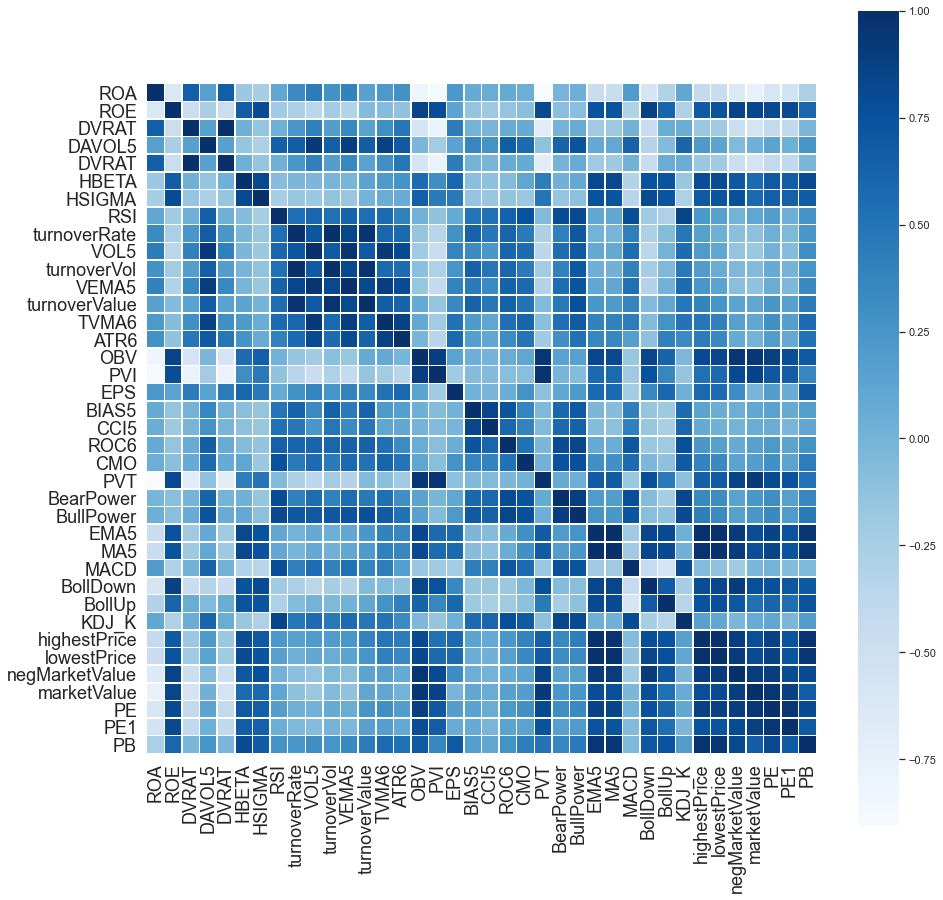

In [110]:
#各因子的相关系数
X_train_matrix = X_train.corr()

#绘制热力图
sns.set()
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(X_train_matrix, annot=False, square=True, cmap="Blues",
linewidths=.5, vmax=1, ax=ax)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('PA_matrix_1Y_timing.png')
plt.show()

In [111]:
#标准化
#构建特征 feature 部分,
ss_x = StandardScaler()
X_train_scaler = ss_x.fit_transform(X_train)
X_test_scaler = ss_x.transform(X_test)
X_train_scaler

array([[ 1.76, -1.46, -1.22, ..., -1.67, -1.53, -1.21],
       [ 1.76, -1.46,  0.16, ..., -1.8 , -1.63, -1.33],
       [ 1.76, -1.46,  1.43, ..., -2.03, -1.82, -1.55],
       ...,
       [-1.48, -0.55, -1.55, ..., -0.56, -1.57, -0.89],
       [-1.48, -0.55, -1.56, ..., -0.42, -1.47, -0.76],
       [-1.48, -0.55, -1.58, ..., -0.39, -1.45, -0.73]])

In [112]:
X_test_scaler

array([[ -1.48,  -0.55,  -1.37, ...,  -0.49,  -1.52,  -0.82],
       [ -1.48,  -0.55,  -1.51, ...,  -0.75,  -1.71,  -1.05],
       [ -1.48,  -0.55,  -1.52, ...,  -0.73,  -1.7 ,  -1.04],
       ...,
       [ -6.87, -42.15,   9.01, ...,  -0.74,  -1.15,  -3.14],
       [ -6.87, -42.15,   9.65, ...,  -0.67,  -1.1 ,  -3.1 ],
       [ -6.87, -42.15,   8.8 , ...,  -0.27,  -0.78,  -2.84]])

In [113]:
#使用网格搜索/交叉验证，GridSearchCV/ Crossvalidation，使用 C 和 gamma 的参数集
#构造字典-参数集 1
param_1 = [
{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10 ,100, 1000], 'kernel':['linear']},
{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10 ,100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel':['rbf']},
]
grid_1 = GridSearchCV(SVC(), param_1, cv=5)
#训练模型
grid_1.fit(X_train_scaler, Y_train)
grid_1.best_estimator_
grid_1.scorer_
pred_3 = grid_1.predict(X_test_scaler)
score_3 = grid_1.score(X_train_scaler, Y_train)
#准确率和准确个数
accuracy_3 = metrics.accuracy_score(Y_test, pred_3)
num_3 = metrics.accuracy_score(Y_test, pred_3, normalize=False)
precision_3 = metrics.precision_score(Y_test, pred_3)
recall_3 = metrics.recall_score(Y_test, pred_3)
f1_score_3 = metrics.f1_score(Y_test, pred_3)
#构建结果
results = DataFrame(index=['score', 'accuracy', 'num of acc', 'precision', 'recall', 'f1_score'])
results['Model_1'] = [score_3, accuracy_3, num_3, precision_3, recall_3, f1_score_3]
results

,Model_1
score,0.594737
accuracy,0.510638
num of acc,528.000000
precision,0.508716
recall,0.620890
f1_score,0.559233


In [114]:
# %matplotlib inline
#定义画混淆矩阵的函数
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [115]:
#定义回测时收益率情况的三个指标函数
def ratio(data):
    accum_re = (data + 1).cumprod()
    #年化收益率
    ann_re = accum_re.tolist()[-1] ** (252 / accum_re.shape[0]) - 1
    #波动率
    volatility = data.std() * 252 ** 0.5
    #最大回撤率
    max_drawback = ((accum_re.cummax() - accum_re) /
    accum_re.cummax()).max()
    re = pd.DataFrame([ann_re, volatility, max_drawback], columns=[data.name],
    index=['年化收益率', '历史波动率', '最大回撤率'])
    return re

Confusion matrix, without normalization
[[207 310]
 [196 321]]


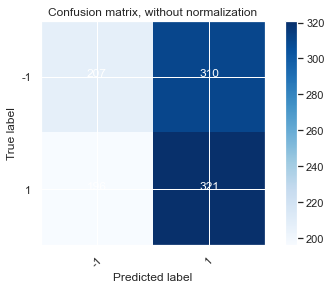

In [116]:
#混淆矩阵
cnf_matrix_3 = confusion_matrix(Y_test, pred_3)
np.set_printoptions(precision=2)

# 绘制非标准的混淆矩阵
plt.figure()
plot_confusion_matrix(cnf_matrix_3, classes=[-1, 1], title='Confusion matrix, without normalization')

In [117]:
#在标准化的基础上进行 PCA
#设置阈值为 95%
pca = PCA(n_components=0.95)
pca.fit(X_train_scaler)
#主成分
pca.components_
pca.components_.shape
#主成分的个数
pca.n_components_
pca.explained_variance_ratio_

array([0.38, 0.31, 0.13, 0.04, 0.04, 0.02, 0.02, 0.01])

In [118]:
#使用相应的 PCA 参数对 feature 部分进行降维，首先是训练集
X_train_scaler_pca = pca.transform(X_train_scaler)
X_train_scaler_pca.shape

(190, 8)

In [119]:
#使用同样的 PCA 参数对测试集进行降维X_test_scaler_pca = pca.transform(X_test_scaler)
X_test_scaler_pca = pca.transform(X_test_scaler)
X_test_scaler_pca.shape

(1034, 8)

In [120]:
#此模型，PCA 后使用 Gridsearch CV 进行参数优化
#沿用参数集 1
#构造交叉函数
grid_2 = GridSearchCV(SVC(), param_1, cv=5)
#训练模型
grid_2.fit(X_train_scaler_pca, Y_train)
grid_2.best_estimator_
grid_2.scorer_
#预测结果
pred_6 = grid_2.predict(X_test_scaler_pca)
score_6 = grid_2.score(X_train_scaler_pca, Y_train)
#准确率和准确个数
accuracy_6 = metrics.accuracy_score(Y_test, pred_6)
num_6 = metrics.accuracy_score(Y_test, pred_6, normalize=False)
precision_6 = metrics.precision_score(Y_test, pred_6)
recall_6 = metrics.recall_score(Y_test, pred_6)
f1_score_6 = metrics.f1_score(Y_test, pred_6)
accuracy_6

0.5019342359767892

In [121]:
results['Model_2'] = [score_6, accuracy_6, num_6, precision_6, recall_6, f1_score_6]
results


,Model_1,Model_2
score,0.594737,0.973684
accuracy,0.510638,0.501934
num of acc,528.000000,519.000000
precision,0.508716,0.500969
recall,0.620890,1.000000
f1_score,0.559233,0.667527


Confusion matrix, without normalization
[[  2 515]
 [  0 517]]


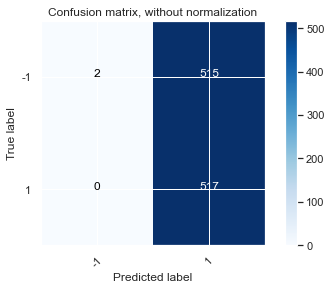

In [122]:
#混淆矩阵
cnf_matrix_6 = confusion_matrix(Y_test, pred_6)
np.set_printoptions(precision=2)
# 绘制非标准的混淆矩阵
plt.figure()
plot_confusion_matrix(cnf_matrix_6, classes=[-1, 1], title='Confusion matrix, without normalization')

,Benchmark,Model_1,Model_2
年化收益率,-0.052777,0.197831,0.373856
历史波动率,0.358681,0.180680,0.301335
最大回撤率,0.567172,0.376905,0.376905


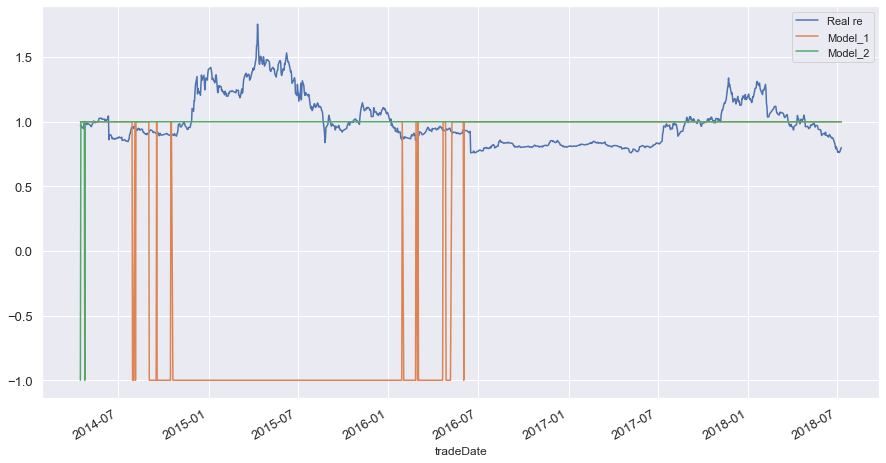

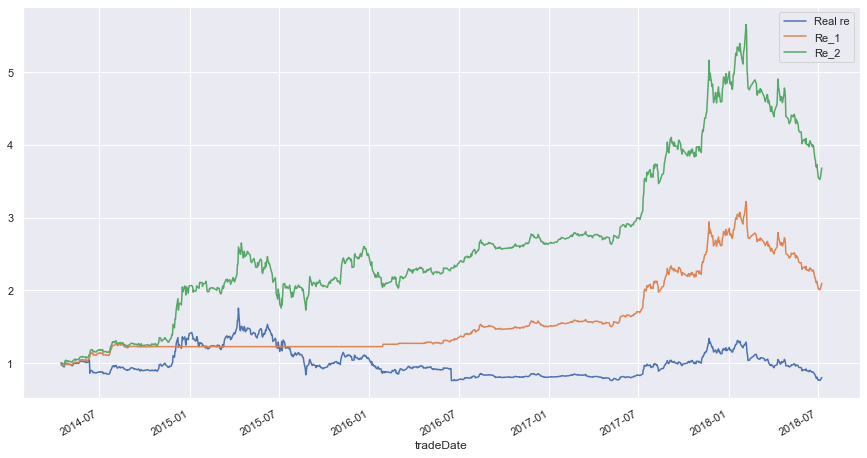

In [133]:
#取收盘价，计算收益率曲线
re_data = DataFrame(index=data_1[num:].index)
re_data['Real Open'] = data['openPrice'].iloc[num:]
re_data['Real Close'] = data['closePrice'].iloc[num:]
re_data['Real re'] = (re_data['Real Close'].pct_change() + 1).cumprod()
re_data['Model_1'] = pred_3
re_data['Model_2'] = pred_6
re_data
#对预测结果进行平移，因为都是通过前一天预测后一天的涨跌，之后进行回测都是要用当天的进行匹配
re_data['Model_1'] = re_data['Model_1'].shift(1)
re_data['Model_2'] = re_data['Model_2'].shift(1)
re_data
#画图
re_data.plot(y=['Real re', 'Model_1', 'Model_2'],
use_index=True,
fontsize=14,
grid=True,
figsize=(15, 8))
# 设置刻度字体大小
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#回测
re_data['PL_1'] = np.where(re_data['Model_1']==1, (re_data['Real Close'] -
re_data['Real Open']) / re_data['Real Open'], 0)
re_data['PL_2'] = np.where(re_data['Model_2']==1, (re_data['Real Close'] -
re_data['Real Open']) / re_data['Real Open'], 0)
#累计收益率
re_data['Re_1'] = (re_data['PL_1'] + 1).cumprod()
re_data['Re_2'] = (re_data['PL_2'] + 1).cumprod()
re_data
# +
re_data.plot(y=['Real re', 'Re_1', 'Re_2'],
use_index=True,
fontsize=11,
grid=True,
figsize=(15, 8))

#计算投资收益的三个指标，年化收益率，波动率和最大回撤率
#添加实际和两个策略的参数
data_ratio = ratio(re_data['Real Close'].pct_change()).join(ratio(re_data['PL_1'])).join(ratio(re_data['PL_2']))
data_ratio.columns = ['Benchmark', 'Model_1', 'Model_2']
data_ratio
